# Calibration notebook

About this notebook, we've divided it into the 4 following parts:

1. **Predictions loading**: We load a CSV file with the predictions concerning the model to evaluate.
2. **Evaluations loading**: We load a CSV file with the evaluations concerning the model to evaluate.
3. **Calibrator fit**: After specifying the target measure of interest (e.g., f1-score, accuracy), we fit some calibration models to the transformed predictions using the aforementioned predictions. This introduces some limitations in terms of the granularity of the metrics -- are we fitting it into a discrete/categorical or continuous variable?
5. **Dump calibrated predictions** and **model**: After fitting the model we store the model checkpoint as well as its predictions in the specified folders.


**Note**: We assume that all of these files will have a set of index columns through which we can jointly align them.


In [27]:
ROOT_DIR = "../outputs/results/mocha/narrativeqa/dev4"

EVALS_TOKENIZER = "default"
# TODO - Come up with some uuid (model_name + dataset + split)
PREDS_FILEPATH = f"{ROOT_DIR}/preds/dev4-uqa-t5-small_preds.csv.gz"
EVALS_FILEPATH = f"{ROOT_DIR}/evals/{EVALS_TOKENIZER}_dev4-uqa-t5-small_evals.csv.gz"

# Arguments used to read the files from disk
csv_kwargs = {
   "compression": "gzip"
}

ID_COLS = ["example_id", "answer_id"]
UNIQUE_ID_COL = ID_COLS[0]

# The name of the feature in the target that we're trying to calibrate towards
UNCALIBRATED_SCORE_COLS = ["score_proba", "score_proba_arithm", "score_proba_geom", "score_proba_std"]

# The metric we're calibrating w.r.t.
CALIBRATION_TARGET = "f1_score"

In [31]:
# TODO - MODEL UUID
CALIB_RESULTS_DIR = f"{ROOT_DIR}/calib"
CALIB_UUID = f"lr-mse-{CALIBRATION_TARGET}"

CALIB_PREDS_FILEPATH = f"{CALIB_RESULTS_DIR}/preds/dev4-uqa-t5-small-{CALIB_UUID}_preds.csv.gz"
!mkdir -p {CALIB_RESULTS_DIR}/preds

CALIB_MODEL_FILEPATH = f"{CALIB_RESULTS_DIR}/models/dev4-uqa-t5-small-{CALIB_UUID}_model.joblib"
!mkdir -p {CALIB_RESULTS_DIR}/models

CALIB_MODEL_METADATA = f"{CALIB_RESULTS_DIR}/models/dev4-uqa-t5-small-{CALIB_UUID}"

CALIB_EVALS_GLOBAL_FILEPATH = f"{CALIB_RESULTS_DIR}/evals/dev4-uqa-t5-small-{CALIB_UUID}_evals"
!mkdir -p {CALIB_RESULTS_DIR}/evals

In [32]:
import pandas as pd
import numpy as np

## Predictions & Evaluations loading

In [34]:
preds = pd.read_csv(PREDS_FILEPATH, **csv_kwargs).set_index(ID_COLS)
evals = pd.read_csv(EVALS_FILEPATH, **csv_kwargs).set_index(ID_COLS)

# Even though we have an evaluation for each instance in the dataset
# the predictions are not duplicated across different data points
# hence requiring some filtering to make the two matrices of the same size.
_evals_cols = evals.columns
evals  = preds.join(evals, how="left")[_evals_cols]
assert len(preds) == len(evals)

y_true = evals[CALIBRATION_TARGET]

In [35]:
evals.head()

,,exact_match,first_error_position,precision,recall,f1_score,csi,rouge1,rouge2,rougeL,rougeLsum,meteor,metric_type
example_id,answer_id,,,,,,,,,,,,
f485d3509a0606a7b570cc5f2edbd083,e2fd235719de9140057fdb4e61e930e9,1,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.9375,performance
921d4e8c8c14e3b385bb80546b792154,b1a98f8723f1df6c2a71c2ce80f8af52,1,NaN,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.5000,performance
6a1962b5dbe9a81cb75bb07dbf5669ef,e9ae37f4295ebdd6784bee441be81df4,1,NaN,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.5000,performance
1a1d261030142098c1bfeb7cb89d796e,5ef799ab36e56957ee6cb47ed2b7d47b,1,NaN,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.5000,performance
675936324cb453372def083ee268e7ca,f8f5f8da83093b4a291abc0328431a00,1,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.9375,performance


In [36]:
preds.head()

,,preds,score_proba,score_proba_geom,score_proba_arithm,score_proba_std
example_id,answer_id,,,,,
f485d3509a0606a7b570cc5f2edbd083,e2fd235719de9140057fdb4e61e930e9,court compliment,0.310726,0.677318,0.725339,0.448770
921d4e8c8c14e3b385bb80546b792154,b1a98f8723f1df6c2a71c2ce80f8af52,pablo,0.787864,0.923600,0.928995,0.364561
6a1962b5dbe9a81cb75bb07dbf5669ef,e9ae37f4295ebdd6784bee441be81df4,numedides,0.840100,0.957377,0.959353,0.343168
1a1d261030142098c1bfeb7cb89d796e,5ef799ab36e56957ee6cb47ed2b7d47b,edward,0.707771,0.933208,0.940886,0.324931
675936324cb453372def083ee268e7ca,f8f5f8da83093b4a291abc0328431a00,the black cloak,0.449724,0.875301,0.890707,0.361864


## Calibration methods

In this section, we're running logistic regression calibration and beta regression calibration techniques to fit a monotonic curve to map from the provided data to the specified one.

In [37]:
import matplotlib.pyplot as plt
import ml_insights as mli

import seaborn as sns

About the plot:
- Length of the acceptance intervals gets larger as we have less data points.
- Ideal: have good calibration across all areas -- (awful result is to have good calibration in rare regions).
- If too little data - may consider merging bins. I'm not confident that this will is useful for NLP in practice.

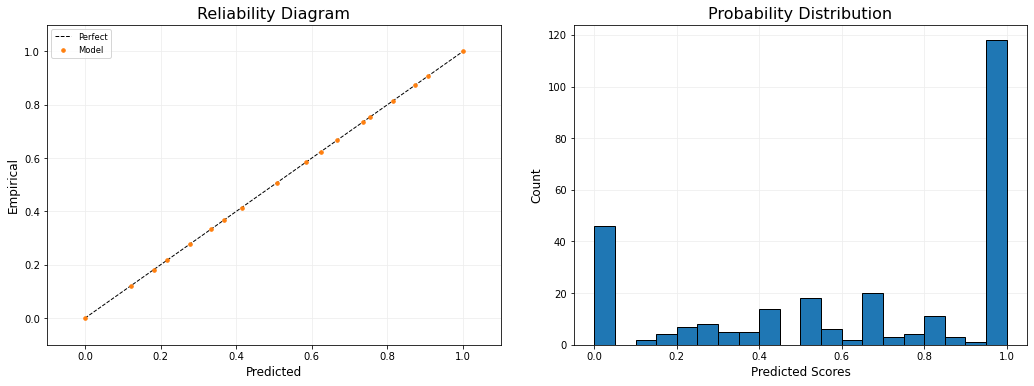

In [38]:
# Distribution of the f1 scores
plt.figure(figsize=(15, 6)); mli.plot_reliability_diagram(y_true, y_true, error_bars=False, show_histogram=True);

###  Before calibration

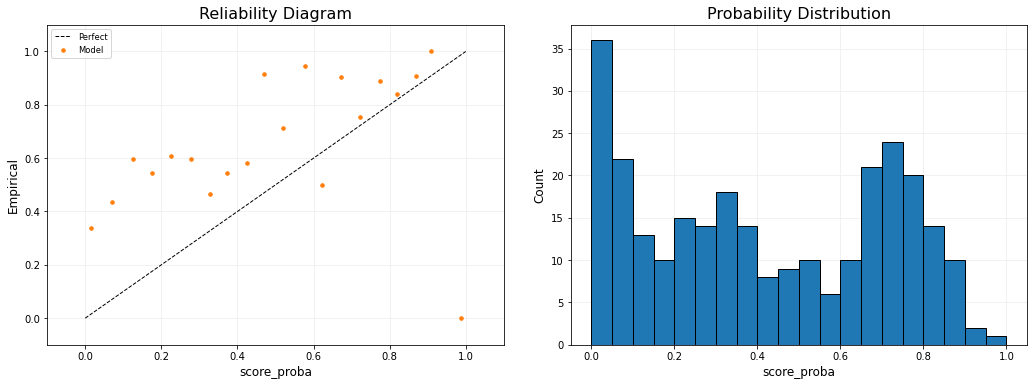

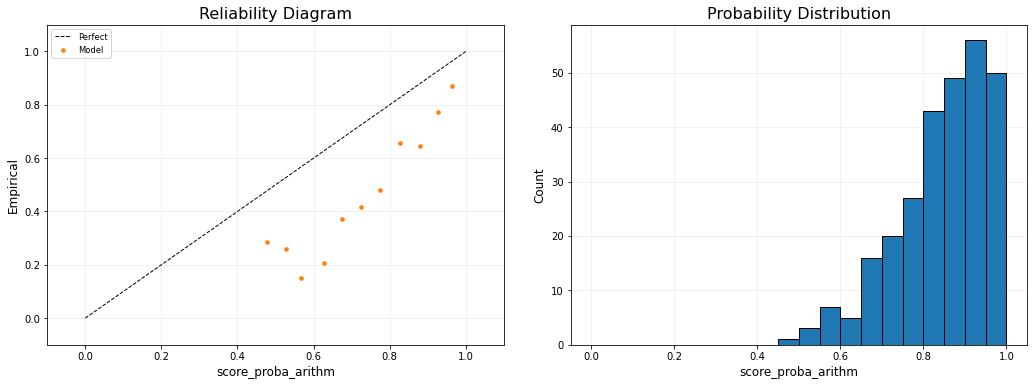

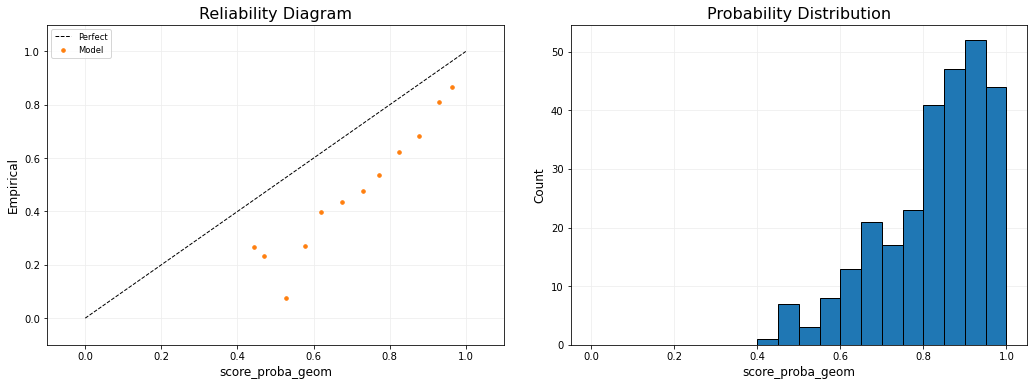

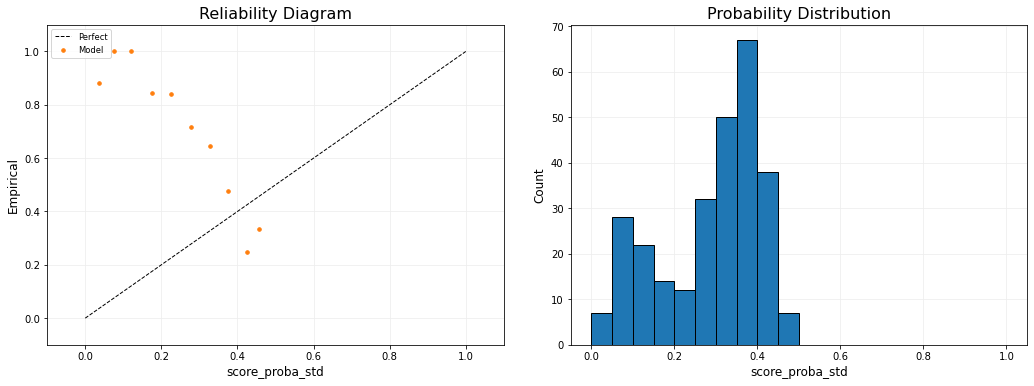

In [39]:
for col in UNCALIBRATED_SCORE_COLS:
    # Uncalibrated and calibrated values
    x = preds[col]
    y_true = evals[CALIBRATION_TARGET]
    plt.figure(figsize=(15, 6)); mli.plot_reliability_diagram(y=y_true, x=x, ax1_x_title=col, ax2_x_title=col, error_bars=False, show_histogram=True);

### Logistic Regression (continuous version) w/ MSE

Saved figure at ../outputs/results/mocha/narrativeqa/dev4/calib/models/dev4-uqa-t5-small-lr-mse-f1_score-score_proba.svg
Saved figure at ../outputs/results/mocha/narrativeqa/dev4/calib/models/dev4-uqa-t5-small-lr-mse-f1_score-score_proba_arithm.svg
Saved figure at ../outputs/results/mocha/narrativeqa/dev4/calib/models/dev4-uqa-t5-small-lr-mse-f1_score-score_proba_geom.svg
Saved figure at ../outputs/results/mocha/narrativeqa/dev4/calib/models/dev4-uqa-t5-small-lr-mse-f1_score-score_proba_std.svg


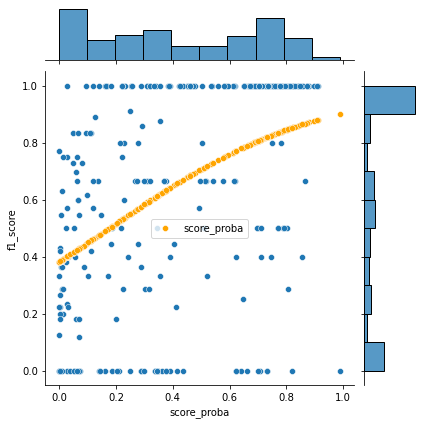

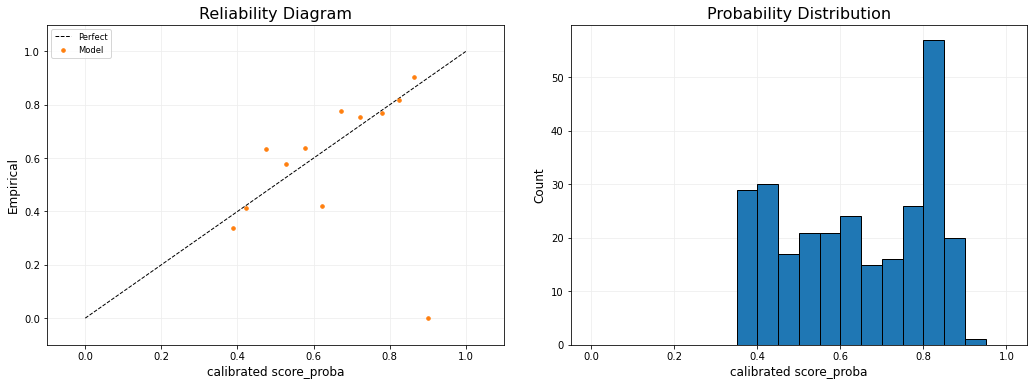

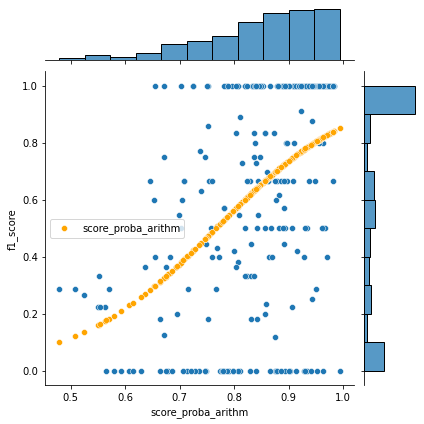

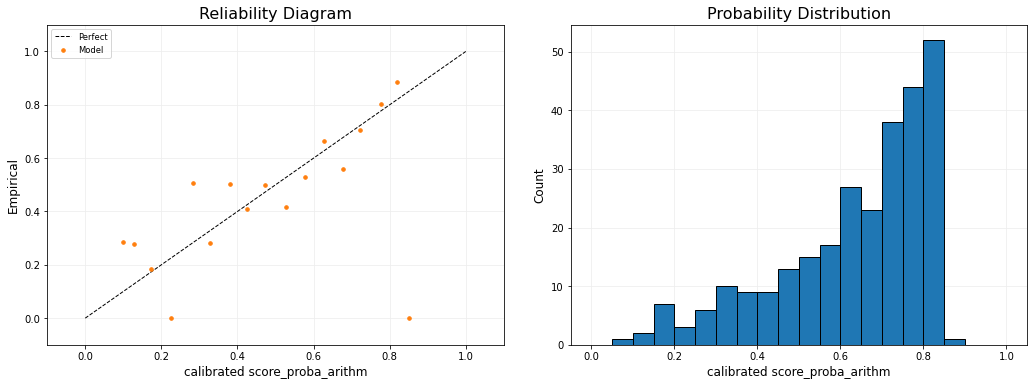

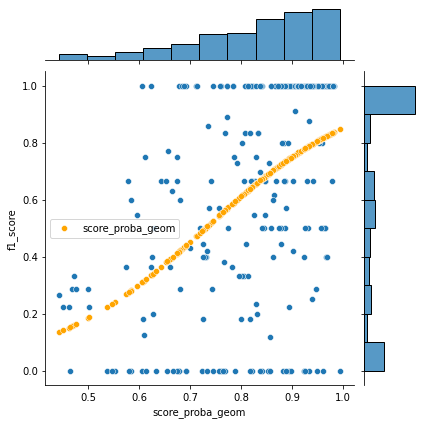

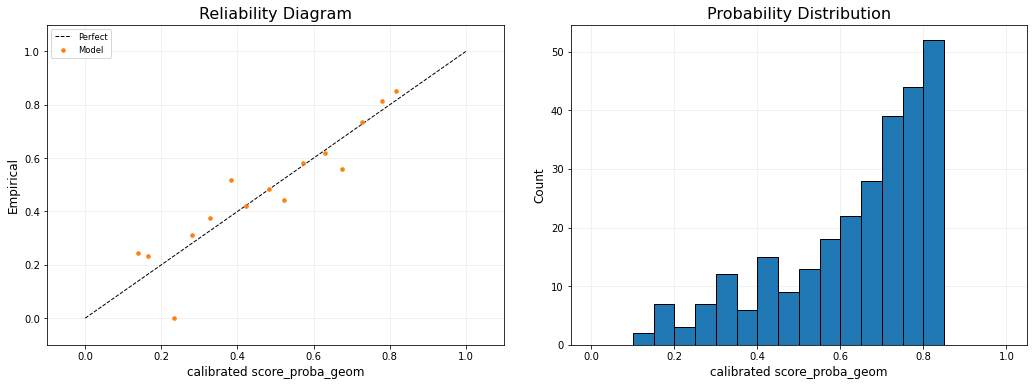

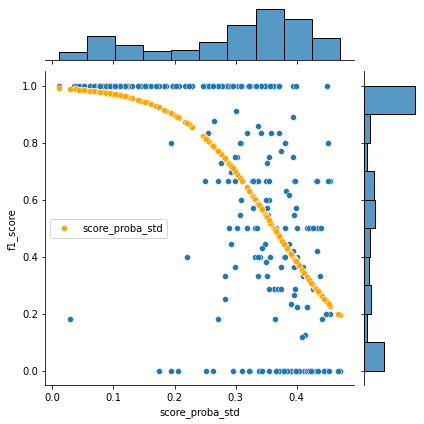

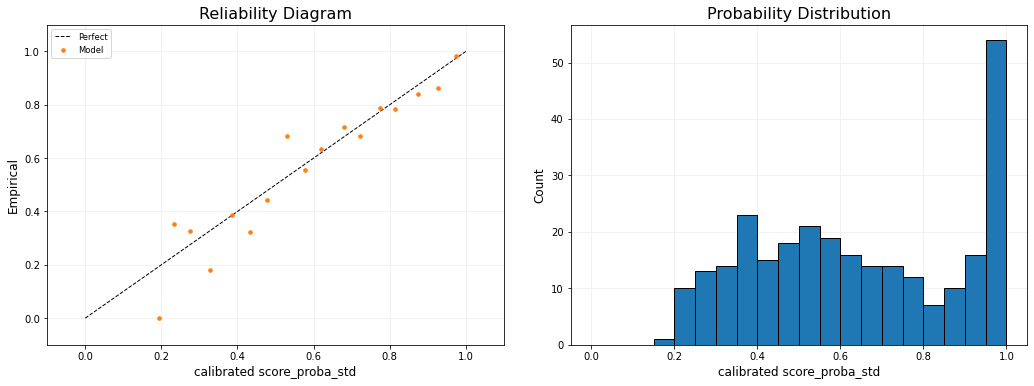

In [40]:
from logistic import LogisticRegression


model_classpath = LogisticRegression
model_hyperparams = {}

lr_preds = preds.copy()
for col in UNCALIBRATED_SCORE_COLS:
    # Uncalibrated and calibrated values
    x = preds[col]
    y_true = evals[CALIBRATION_TARGET]
    
    model = model_classpath(**model_hyperparams)
    model.fit(x, y_true)

    y_pred = model.predict(x)
    
    # We re-use the same structure as the preds we've loaded initially
    # write them into a calibrated predictions file.
    lr_preds[col] = y_pred
    
    g = sns.jointplot(x=x, y=y_true)
    sns.scatterplot(x=x, y=y_pred, color="orange", ax=g.ax_joint, label=col)
    
    fig_name = f"{CALIB_MODEL_METADATA}-{col}.svg"
    plt.savefig(fig_name, dpi=300)
    print("Saved figure at", fig_name)
    
    # Distribution of f1-scores in function of y_original (uncalibrated scores)
    plt.figure(figsize=(15, 6)); mli.plot_reliability_diagram(y=y_true, x=y_pred, ax1_x_title=f"calibrated {col}", ax2_x_title=f"calibrated {col}", error_bars=False, show_histogram=True);

In [41]:
pd.concat((preds, y_true), axis=1).describe()

,score_proba,score_proba_geom,score_proba_arithm,score_proba_std,f1_score
count,277.000000,277.000000,277.000000,277.000000,277.000000
mean,0.419934,0.823615,0.845261,0.288300,0.639032
std,0.290176,0.129196,0.109410,0.122059,0.382494
min,0.000010,0.442364,0.478782,0.011185,0.000000
25%,0.142491,0.744385,0.782029,0.195306,0.333333
50%,0.387272,0.856701,0.874490,0.330034,0.727273
75%,0.701247,0.931115,0.934785,0.381095,1.000000
max,0.987379,0.993670,0.993670,0.470264,1.000000


In [42]:
lr_preds["calibration_target"] = CALIBRATION_TARGET
lr_preds["model_classpath"] = model_classpath.__module__ + "." + model_classpath.__name__
lr_preds["model_hyperparams"] = model_hyperparams or str(dict())
lr_preds["model_config_filepath"] = CALIB_MODEL_FILEPATH
lr_preds.describe()

,score_proba,score_proba_geom,score_proba_arithm,score_proba_std
count,277.000000,277.000000,277.000000,277.000000
mean,0.639872,0.635355,0.634965,0.640742
std,0.167734,0.181789,0.181706,0.243713
min,0.382009,0.135941,0.099272,0.193497
25%,0.476667,0.524290,0.529970,0.439102
50%,0.639348,0.694483,0.696152,0.606452
75%,0.806390,0.785969,0.784384,0.901971
max,0.900712,0.846055,0.851060,0.990635


In [43]:
y_true.describe()

count    277.000000
mean       0.639032
std        0.382494
min        0.000000
25%        0.333333
50%        0.727273
75%        1.000000
max        1.000000
Name: f1_score, dtype: float64

## Store model and calibrated predictions

In [44]:
import joblib
import yaml

In [45]:
lr_preds.to_csv(CALIB_PREDS_FILEPATH, **csv_kwargs)
print("Wrote predictions to", CALIB_PREDS_FILEPATH)

# Sanity check
pd.read_csv(CALIB_PREDS_FILEPATH, **csv_kwargs)

Wrote predictions to ../outputs/results/mocha/narrativeqa/dev4/calib/preds/dev4-uqa-t5-small-lr-mse-f1_score_preds.csv.gz


,example_id,answer_id,preds,score_proba,score_proba_geom,score_proba_arithm,score_proba_std,calibration_target,model_classpath,model_hyperparams,model_config_filepath
0,f485d3509a0606a7b570cc5f2edbd083,e2fd235719de9140057fdb4e61e930e9,court compliment,0.590079,0.417016,0.421971,0.241884,f1_score,logistic.LogisticRegression,{},../outputs/results/mocha/narrativeqa/dev4/cali...
1,921d4e8c8c14e3b385bb80546b792154,b1a98f8723f1df6c2a71c2ce80f8af52,pablo,0.840556,0.777707,0.776779,0.493621,f1_score,logistic.LogisticRegression,{},../outputs/results/mocha/narrativeqa/dev4/cali...
2,6a1962b5dbe9a81cb75bb07dbf5669ef,e9ae37f4295ebdd6784bee441be81df4,numedides,0.858693,0.813067,0.814541,0.564198,f1_score,logistic.LogisticRegression,{},../outputs/results/mocha/narrativeqa/dev4/cali...
3,1a1d261030142098c1bfeb7cb89d796e,5ef799ab36e56957ee6cb47ed2b7d47b,edward,0.809146,0.788229,0.792190,0.622484,f1_score,logistic.LogisticRegression,{},../outputs/results/mocha/narrativeqa/dev4/cali...
4,675936324cb453372def083ee268e7ca,f8f5f8da83093b4a291abc0328431a00,the black cloak,0.677529,0.719312,0.721798,0.502565,f1_score,logistic.LogisticRegression,{},../outputs/results/mocha/narrativeqa/dev4/cali...
...,...,...,...,...,...,...,...,...,...,...,...
272,159e9b469758f1cc6eeac013bd18a9db,3541ca5d5f8fc10a7954020ff6259a40,raphael,0.423624,0.347964,0.387111,0.444922,f1_score,logistic.LogisticRegression,{},../outputs/results/mocha/narrativeqa/dev4/cali...
273,f60bdcc6403153595ef91a23c2610ac0,57969ef43933681ffc5b151cb637531c,frank tregear,0.788924,0.805376,0.806361,0.665490,f1_score,logistic.LogisticRegression,{},../outputs/results/mocha/narrativeqa/dev4/cali...
274,bb367ed82eecadcc793ad672cf75bc21,764587468753def4644d0a675f5d29bc,oreste,0.806390,0.736077,0.736239,0.565680,f1_score,logistic.LogisticRegression,{},../outputs/results/mocha/narrativeqa/dev4/cali...
275,92cf35db62a8b8b885ae6bd88b74796e,83eeb53928af196b2521ec80c13d3594,alexandria,0.582936,0.673935,0.715801,0.308914,f1_score,logistic.LogisticRegression,{},../outputs/results/mocha/narrativeqa/dev4/cali...


In [46]:
joblib.dump(model, CALIB_MODEL_FILEPATH)

with open(CALIB_MODEL_METADATA + ".metadata", "w") as metadata_file:
    yaml.dump({
        "model_classpath": f"{model_classpath.__module__}.{model_classpath.__qualname__}",
        "model_hyperparams": model_hyperparams,
    }, metadata_file)
    
!ls -altrh {CALIB_RESULTS_DIR}/models

total 408K
drwxrwxr-x 5 kat kat 4.0K Feb 23 11:23 ..
drwxrwxr-x 2 kat kat 4.0K Feb 23 11:30 .
-rw-rw-r-- 1 kat kat  94K Feb 23 11:43 dev4-uqa-t5-small-lr-mse-f1_score-score_proba.svg
-rw-rw-r-- 1 kat kat  98K Feb 23 11:43 dev4-uqa-t5-small-lr-mse-f1_score-score_proba_arithm.svg
-rw-rw-r-- 1 kat kat  97K Feb 23 11:43 dev4-uqa-t5-small-lr-mse-f1_score-score_proba_geom.svg
-rw-rw-r-- 1 kat kat  95K Feb 23 11:43 dev4-uqa-t5-small-lr-mse-f1_score-score_proba_std.svg
-rw-rw-r-- 1 kat kat  337 Feb 23 11:44 dev4-uqa-t5-small-lr-mse-f1_score_model.joblib
-rw-rw-r-- 1 kat kat   67 Feb 23 11:44 dev4-uqa-t5-small-lr-mse-f1_score.metadata


## Evaluate Calibration results

In [47]:
CORR_METRICS_SUFFIX = "correlation_metrics"
CALIB_METRICS_SUFFIX = "calib_metrics"

In [48]:
import metrics as m

SCORE_COLS = UNCALIBRATED_SCORE_COLS

# Validation of the scores range
for col in SCORE_COLS:
    assert 0 < min(lr_preds[col]), f"{col} col is less than 0"
    assert max(lr_preds[col]) <= 1, f"{col} col is greater than 1"

    
GLOBAL_METRICS = evals.join(lr_preds, how="left")

In [49]:
REFERENCE_METRICS = [CALIBRATION_TARGET] 

# -----------------------------------------------------------------
GLOBAL_METRICS = GLOBAL_METRICS.reset_index()
print("Before de-duplication of data:", len(GLOBAL_METRICS))

_temp = GLOBAL_METRICS.sort_values(REFERENCE_METRICS, ascending=False)
GLOBAL_METRICS_UNIQUE = GLOBAL_METRICS[~_temp.duplicated(UNIQUE_ID_COL)].set_index(ID_COLS)

print("After de-duplication of data:", len(GLOBAL_METRICS_UNIQUE))
# -----------------------------------------------------------------
GLOBAL_METRICS_UNIQUE.info()

Before de-duplication of data: 277
After de-duplication of data: 277
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 277 entries, ('f485d3509a0606a7b570cc5f2edbd083', 'e2fd235719de9140057fdb4e61e930e9') to ('69fb15c137edf9c225875ffa7112906a', 'e23c2e8728e615c361a843ec13823480')
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   exact_match            277 non-null    int64  
 1   first_error_position   159 non-null    float64
 2   precision              277 non-null    float64
 3   recall                 277 non-null    float64
 4   f1_score               277 non-null    float64
 5   csi                    277 non-null    float64
 6   rouge1                 277 non-null    float64
 7   rouge2                 277 non-null    float64
 8   rougeL                 277 non-null    float64
 9   rougeLsum              277 non-null    float64
 10  meteor                 277 non-null    float64
 11  metri

/tmp/ipykernel_15565/4102815749.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  GLOBAL_METRICS_UNIQUE = GLOBAL_METRICS[~_temp.duplicated(UNIQUE_ID_COL)].set_index(ID_COLS)


### Correlation metrics

In [50]:
corr_metrics = []
for score_col in SCORE_COLS:
    score_col_results = m.CorrelationMetric(score_col).compute(GLOBAL_METRICS_UNIQUE, REFERENCE_METRICS)
    score_col_results = score_col_results.dropna()
    corr_metrics.append(score_col_results)
    
corr_metrics = pd.concat(corr_metrics, axis=0).reset_index(drop=True)
corr_metrics

,x,y,pearsonr,pearsonr_pvalue,spearmanr,spearmanr_pvalue,kendall_tau,kendall_tau_pvalue,metric_type
0,f1_score,score_proba,0.438770,1.836467e-14,0.480881,1.952035e-17,0.351780,7.276178e-16,correlation
1,f1_score,score_proba_arithm,0.473408,7.054646e-17,0.493237,2.175117e-18,0.366441,4.391143e-17,correlation
2,f1_score,score_proba_geom,0.474417,5.942077e-17,0.490982,3.267816e-18,0.364017,7.038824e-17,correlation
3,f1_score,score_proba_std,0.633738,1.628122e-32,0.668319,3.291608e-37,0.508678,1.964193e-31,correlation


In [51]:
corr_metrics.to_csv(f"{CALIB_EVALS_GLOBAL_FILEPATH}_{CORR_METRICS_SUFFIX}.csv", index=False)

### Calibration metrics


Amongst the calibration metrics, we have `expected calibration error (ECE)`, `brier score`, `AUC` which quantify the absolute and relative calibrations measures. 


In [52]:
CALIB_METRICS = [CALIBRATION_TARGET]

In [53]:
calib_metrics = []
for calib_metric in CALIB_METRICS:
    calib_results = m.CalibrationMetrics(calib_metric).compute(GLOBAL_METRICS_UNIQUE, SCORE_COLS)
    calib_results = calib_results.dropna()
    
    calib_metrics.append(calib_results)
    
calib_metrics = pd.concat(calib_metrics, axis=0)
calib_metrics

,x,y,mse,mae,ce_avg,ce_std,ECE_eq_width,ECE_eq_width_max,ECE_eq_freq,ECE_eq_freq_max,hyperparams,metric_type
0,f1_score,score_proba,0.117710,0.287901,0.000840,0.343088,0.057514,0.017413,0.053339,0.014022,"{'n_bins': 20, 'frac': 0.1}",calibration
1,f1_score,score_proba_arithm,0.113120,0.281009,-0.004066,0.336309,0.061405,0.012833,0.035962,0.009333,"{'n_bins': 20, 'frac': 0.1}",calibration
2,f1_score,score_proba_geom,0.112977,0.282053,-0.003677,0.336101,0.041551,0.011730,0.053029,0.010756,"{'n_bins': 20, 'frac': 0.1}",calibration
3,f1_score,score_proba_std,0.087232,0.218359,0.001711,0.295346,0.049179,0.011582,0.036612,0.011377,"{'n_bins': 20, 'frac': 0.1}",calibration


In [54]:
calib_metrics.describe().to_csv(f"{CALIB_EVALS_GLOBAL_FILEPATH}_{CALIB_METRICS_SUFFIX}.csv", index=False)

In [55]:
CALIB_EVALS_GLOBAL_FILEPATH

'../outputs/results/mocha/narrativeqa/dev4/calib/evals/dev4-uqa-t5-small-lr-mse-f1_score_evals'